In [1]:
import tensorflow as tf
from Dive_into_deep_learning.d2l import tensorflow as d2l

2023-08-08 14:38:31.989532: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


his design alleviates the vanishing gradient problem, resulting in models that are much easier to train, especially when facing datasets with long sequence lengths ？？？？

In [11]:
class LSTMScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        
        init_weight = lambda *shape: tf.Variable(tf.random.normal(shape) * sigma)
        triple = lambda : (init_weight(num_inputs, num_hiddens),
                           init_weight(num_hiddens, num_hiddens),
                           tf.Variable(tf.zeros(num_hiddens)))
        
        self.W_xf, self.W_hf, self.b_f = triple() # Forget gate
        self.W_xi, self.W_hi, self.b_i = triple() # Input gate
        self.W_xc, self.W_hc, self.b_c = triple() # Input Node
        self.W_xo, self.W_ho, self.b_o = triple() # Output gate
        
    def forward(self, inputs, H_C=None):
        if H_C is None:
            # Initial state with shape: (batch_size, num_hiddens)
            H = tf.zeros((inputs.shape[1], self.num_hiddens))
            C = tf.zeros((inputs.shape[1], self.num_hiddens))
        else:
            H, C = H_C
            
        outputs = []
        for X in inputs:  # (num_steps, batch_size, num_inputs)
            F = tf.sigmoid(tf.matmul(X, self.W_xf) + tf.matmul(C, self.W_hf) + self.b_f)
            I = tf.sigmoid(tf.matmul(X, self.W_xi) + tf.matmul(C, self.W_hi) + self.b_i)
            C_tilde = tf.tanh(tf.matmul(X, self.W_xc) + tf.matmul(C, self.W_hc) + self.b_c)
            O = tf.sigmoid(tf.matmul(X, self.W_xo) + tf.matmul(C, self.W_ho) + self.b_o)
            
            C = F * C + I * C_tilde
            H = O * tf.tanh(C)
            outputs.append(H)      
        return outputs, (H, C)

## Training and Prediction

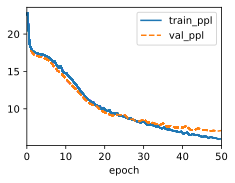

In [12]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
lstm = LSTMScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLMScratch(lstm, vocab_size=len(data.vocab), lr=4)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1)
trainer.fit(model, data)

In [13]:
model.predict('it has', 20, data.vocab)

'it has and the timensions '

# Concise Implementation

KeyboardInterrupt: 

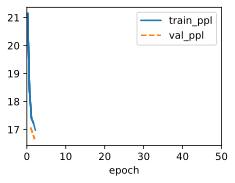

In [14]:
class LSTM(d2l.RNN):
    def __init__(self, num_hiddens):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = tf.keras.layers.LSTM(num_hiddens, return_sequences=True, return_state=True, time_major=True)
        
    def forward(self, inputs, H_C=None):
        outputs, *H_C = self.rnn(inputs, H_C)
        return outputs, H_C
    
lstm = LSTM(num_hiddens=32)
model = d2l.RNNLM(lstm, vocab_size=len(data.vocab), lr=4)
trainer.fit(model, data)